<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})il

In [ ]:
def read_data(url, dataset_name, sep=","):
    r = requests.get(url)
    soup = BeautifulSoup.BeautifulSoup(r.text)
    ressources_list = soup.find("div", "resources-list")
    url = None
    for article in ressources_list.find_all("article"):
      if dataset_name in article.div.h4.text:
        url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
        break
    if url == None:
      raise("data not found")
    return pd.read_csv(url, sep=sep)
    
df = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-nouveaux-covid19",
    ";"
)

df = df[df.jour >= "2020-07-01"]

df.tail()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
19589,976,2020-09-24,0,0,0,0
19590,976,2020-09-25,1,1,0,0
19591,976,2020-09-26,1,1,0,0
19592,976,2020-09-27,0,0,0,1
19593,976,2020-09-28,0,0,0,0


In [ ]:
def display_df(df, title, logscale=False):
    """
    df a pour index les jours et les cols ["incid_hosp", "incid_rea"]
    """
    daily = df[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if False: # daily["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
        disp = ["incid_hosp", "incid_rea", "hosp_desaiso"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea", "rea_lisse"]
        legend = ["hospitalisations", "hospitalisation 7j", "réanimation", "réanimation 7j"]
        disp = ["incid_hosp", "incid_rea", "hosp_lisse", "rea_lisse"]

    plt.figure(figsize=(20,8))
    if logscale:
        plt.yscale('log')
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(title, fontsize=22)
    plt.legend(legend, loc=2, fontsize=14)
    plt.show()
    print("\ndernières données : \n")
    print(dept[disp].apply(np.rint).tail(25))


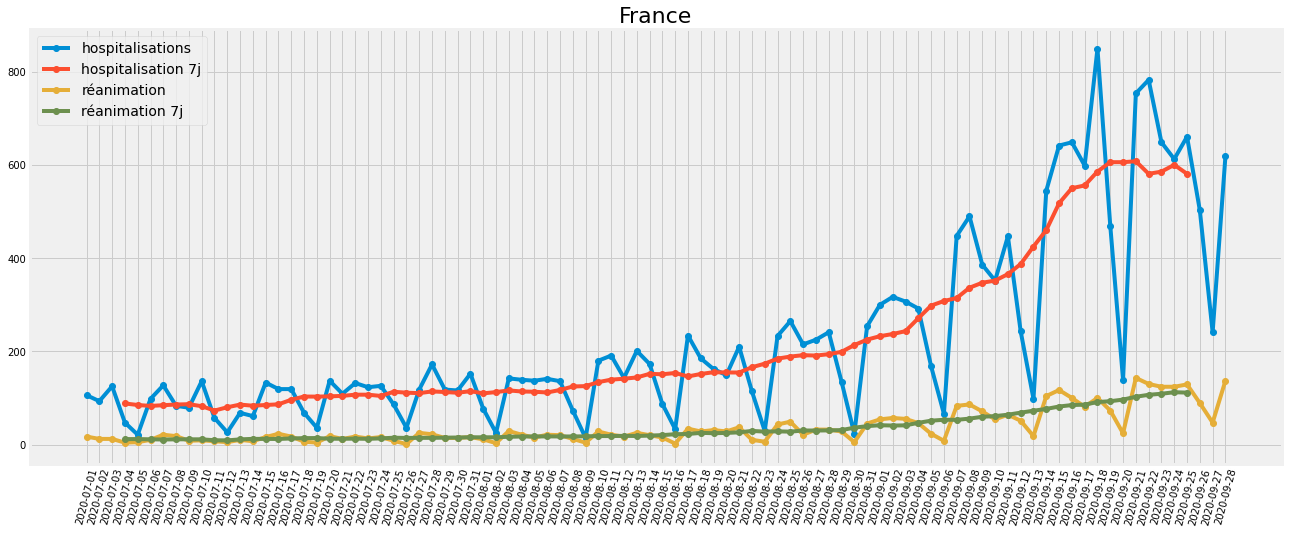


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04       292.0       46.0       271.0       47.0
2020-09-05       168.0       23.0       298.0       51.0
2020-09-06        66.0        8.0       308.0       53.0
2020-09-07       448.0       83.0       315.0       53.0
2020-09-08       490.0       86.0       337.0       56.0
2020-09-09       386.0       71.0       347.0       60.0
2020-09-10       352.0       54.0       352.0       61.0
2020-09-11       447.0       64.0       366.0       64.0
2020-09-12       243.0       51.0       388.0       68.0
2020-09-13        98.0       18.0       425.0       73.0
2020-09-14       545.0      104.0       460.0       76.0
2020-09-15       642.0      117.0       518.0       82.0
2020-09-16       649.0      100.0       550.0       85.0
2020-09-17       599.0       81.0       556.0       86.0
2020-09-18       850.0      100.0       586.0       91.0
2020-09-

In [ ]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France")


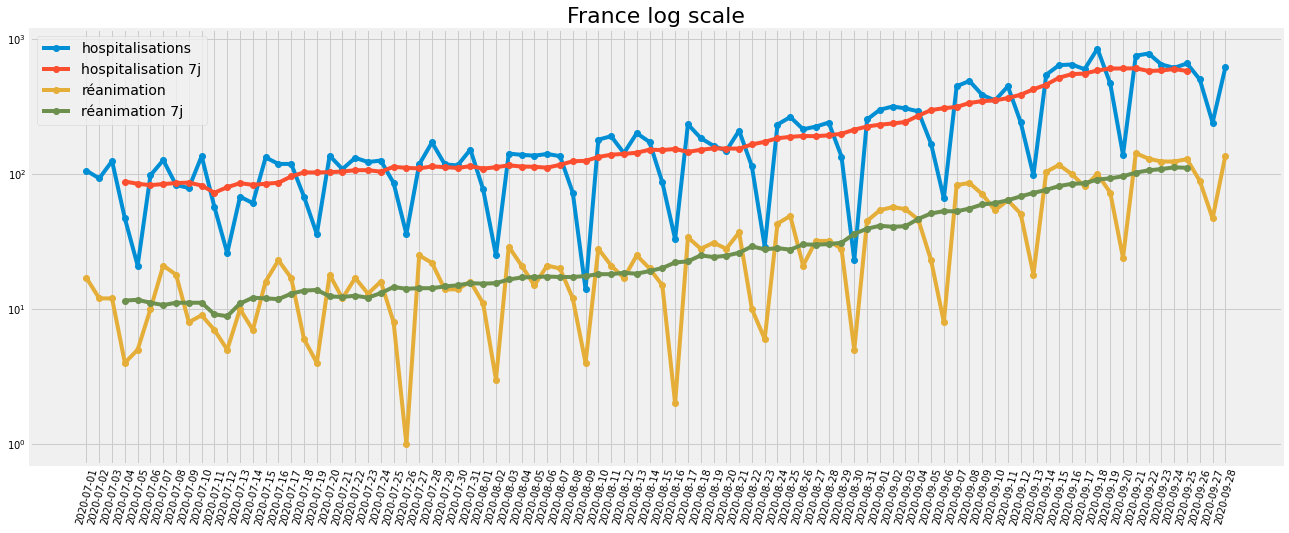


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04       292.0       46.0       271.0       47.0
2020-09-05       168.0       23.0       298.0       51.0
2020-09-06        66.0        8.0       308.0       53.0
2020-09-07       448.0       83.0       315.0       53.0
2020-09-08       490.0       86.0       337.0       56.0
2020-09-09       386.0       71.0       347.0       60.0
2020-09-10       352.0       54.0       352.0       61.0
2020-09-11       447.0       64.0       366.0       64.0
2020-09-12       243.0       51.0       388.0       68.0
2020-09-13        98.0       18.0       425.0       73.0
2020-09-14       545.0      104.0       460.0       76.0
2020-09-15       642.0      117.0       518.0       82.0
2020-09-16       649.0      100.0       550.0       85.0
2020-09-17       599.0       81.0       556.0       86.0
2020-09-18       850.0      100.0       586.0       91.0
2020-09-

In [ ]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France log scale", logscale=True)

In [ ]:
def display_dept(d_number, d_name):
    dept = df[df.dep==d_number]
    dept.set_index(dept.jour, inplace=True)

    daily = dept[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if False: #dept["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea", "rea_lisse"]
        legend = ["hospitalisations", "hospitalisation 7j", "réanimation", "réanimation 7j"]

    plt.figure(figsize=(15,8))
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(d_name, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données lissées 7j: \n")
    print(dept.rolling(7).mean().apply(np.rint).tail())
    

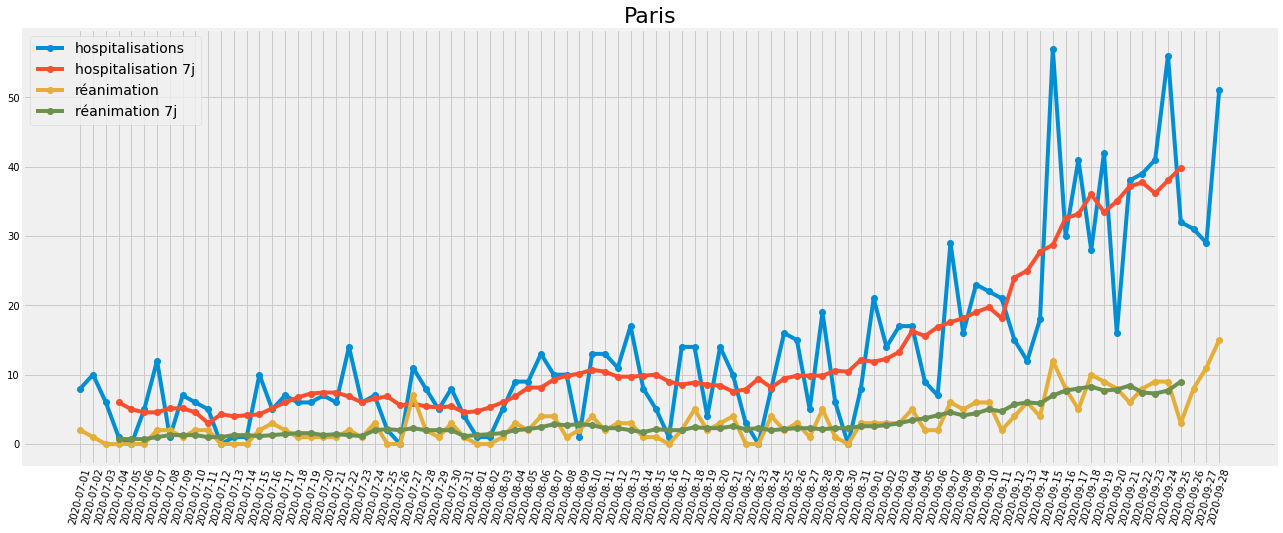


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04        17.0        5.0        16.0        3.0
2020-09-05         9.0        2.0        16.0        4.0
2020-09-06         7.0        2.0        17.0        4.0
2020-09-07        29.0        6.0        18.0        5.0
2020-09-08        16.0        5.0        18.0        4.0
2020-09-09        23.0        6.0        19.0        4.0
2020-09-10        22.0        6.0        20.0        5.0
2020-09-11        21.0        2.0        18.0        5.0
2020-09-12        15.0        4.0        24.0        6.0
2020-09-13        12.0        6.0        25.0        6.0
2020-09-14        18.0        4.0        28.0        6.0
2020-09-15        57.0       12.0        29.0        7.0
2020-09-16        30.0        8.0        33.0        8.0
2020-09-17        41.0        5.0        33.0        8.0
2020-09-18        28.0       10.0        36.0        8.0
2020-09-

In [ ]:
display_df(df[df.dep=="75"].set_index("jour", drop=True), "Paris")

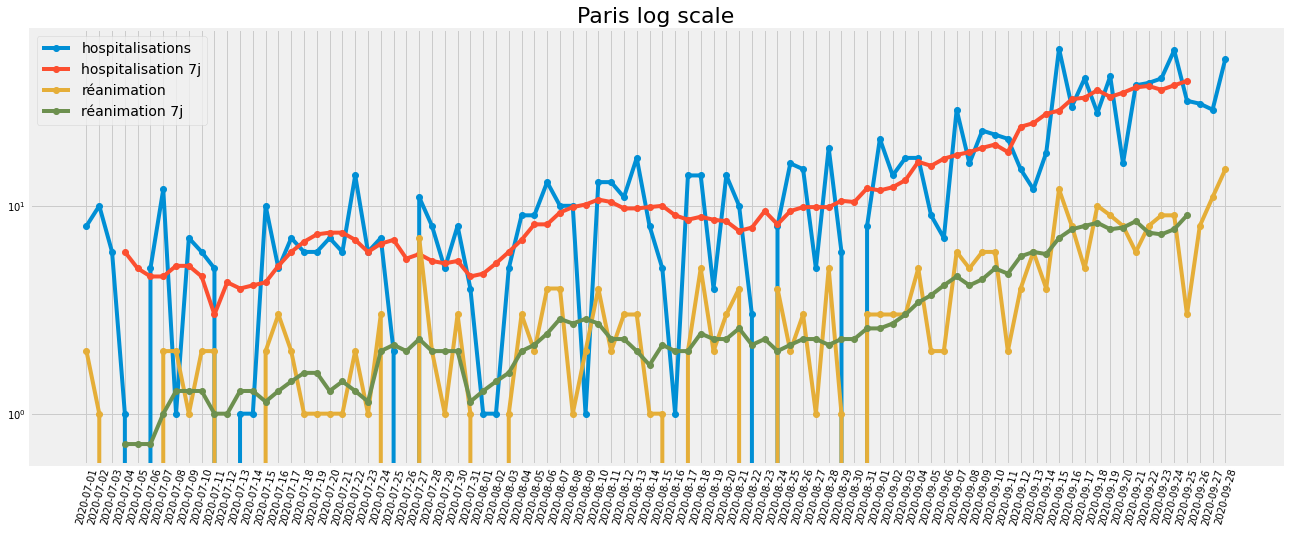


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04        17.0        5.0        16.0        3.0
2020-09-05         9.0        2.0        16.0        4.0
2020-09-06         7.0        2.0        17.0        4.0
2020-09-07        29.0        6.0        18.0        5.0
2020-09-08        16.0        5.0        18.0        4.0
2020-09-09        23.0        6.0        19.0        4.0
2020-09-10        22.0        6.0        20.0        5.0
2020-09-11        21.0        2.0        18.0        5.0
2020-09-12        15.0        4.0        24.0        6.0
2020-09-13        12.0        6.0        25.0        6.0
2020-09-14        18.0        4.0        28.0        6.0
2020-09-15        57.0       12.0        29.0        7.0
2020-09-16        30.0        8.0        33.0        8.0
2020-09-17        41.0        5.0        33.0        8.0
2020-09-18        28.0       10.0        36.0        8.0
2020-09-

In [ ]:
display_df(df[df.dep=="75"].set_index("jour", drop=True), "Paris log scale", True)

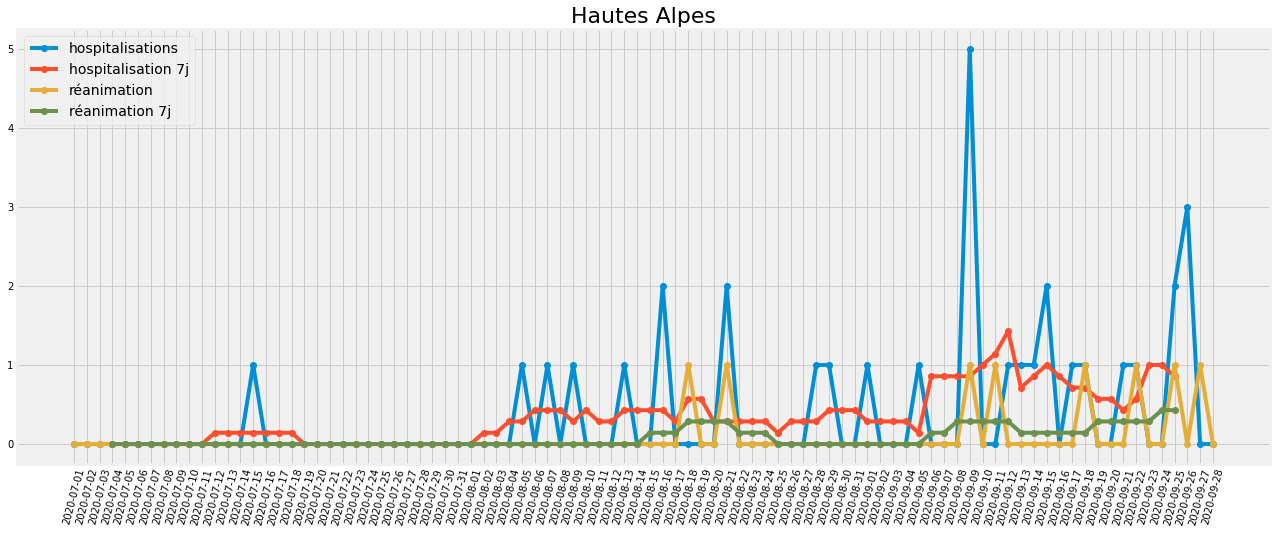


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04         0.0        0.0         0.0        0.0
2020-09-05         1.0        0.0         0.0        0.0
2020-09-06         0.0        0.0         1.0        0.0
2020-09-07         0.0        0.0         1.0        0.0
2020-09-08         0.0        0.0         1.0        0.0
2020-09-09         5.0        1.0         1.0        0.0
2020-09-10         0.0        0.0         1.0        0.0
2020-09-11         0.0        1.0         1.0        0.0
2020-09-12         1.0        0.0         1.0        0.0
2020-09-13         1.0        0.0         1.0        0.0
2020-09-14         1.0        0.0         1.0        0.0
2020-09-15         2.0        0.0         1.0        0.0
2020-09-16         0.0        0.0         1.0        0.0
2020-09-17         1.0        0.0         1.0        0.0
2020-09-18         1.0        1.0         1.0        0.0
2020-09-

In [ ]:
display_df(df[df.dep=="05"].set_index("jour", drop=True),"Hautes Alpes")

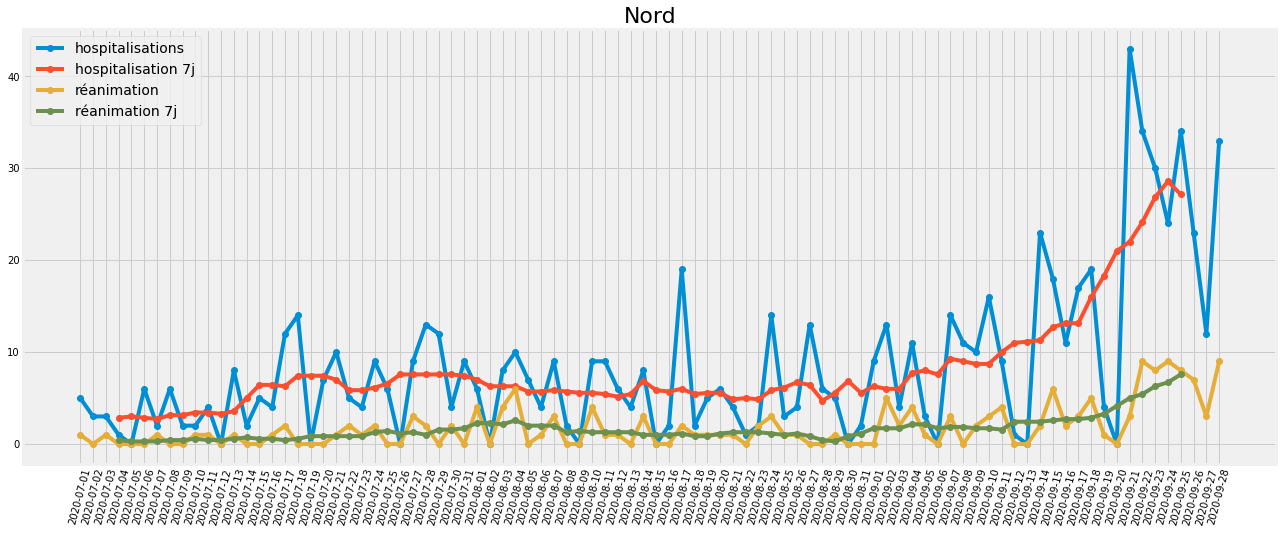


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04        11.0        4.0         8.0        2.0
2020-09-05         3.0        1.0         8.0        2.0
2020-09-06         0.0        0.0         8.0        2.0
2020-09-07        14.0        3.0         9.0        2.0
2020-09-08        11.0        0.0         9.0        2.0
2020-09-09        10.0        2.0         9.0        2.0
2020-09-10        16.0        3.0         9.0        2.0
2020-09-11         9.0        4.0        10.0        2.0
2020-09-12         1.0        0.0        11.0        2.0
2020-09-13         0.0        0.0        11.0        2.0
2020-09-14        23.0        2.0        11.0        2.0
2020-09-15        18.0        6.0        13.0        3.0
2020-09-16        11.0        2.0        13.0        3.0
2020-09-17        17.0        3.0        13.0        3.0
2020-09-18        19.0        5.0        16.0        3.0
2020-09-

In [ ]:
display_df(df[df.dep=="59"].set_index("jour", drop=True),"Nord")

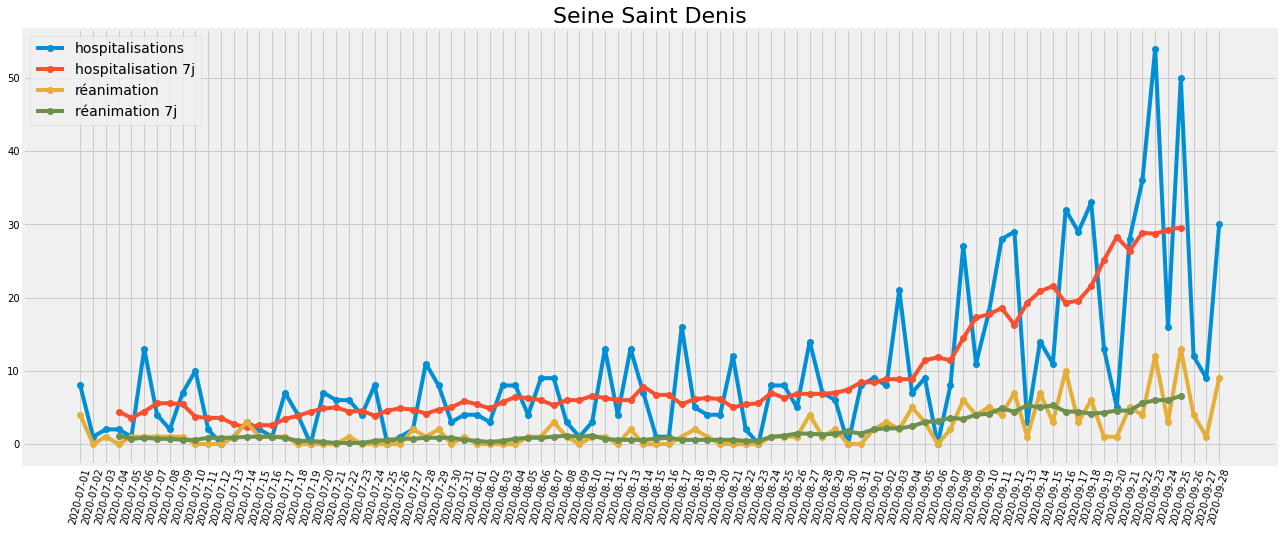


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04         7.0        5.0         9.0        2.0
2020-09-05         9.0        3.0        11.0        3.0
2020-09-06         0.0        0.0        12.0        3.0
2020-09-07         8.0        2.0        11.0        4.0
2020-09-08        27.0        6.0        14.0        3.0
2020-09-09        11.0        4.0        17.0        4.0
2020-09-10        18.0        5.0        18.0        4.0
2020-09-11        28.0        4.0        19.0        5.0
2020-09-12        29.0        7.0        16.0        4.0
2020-09-13         3.0        1.0        19.0        5.0
2020-09-14        14.0        7.0        21.0        5.0
2020-09-15        11.0        3.0        22.0        5.0
2020-09-16        32.0       10.0        19.0        4.0
2020-09-17        29.0        3.0        20.0        4.0
2020-09-18        33.0        6.0        22.0        4.0
2020-09-

In [ ]:
display_df(df[df.dep=="93"].set_index("jour", drop=True),"Seine Saint Denis")

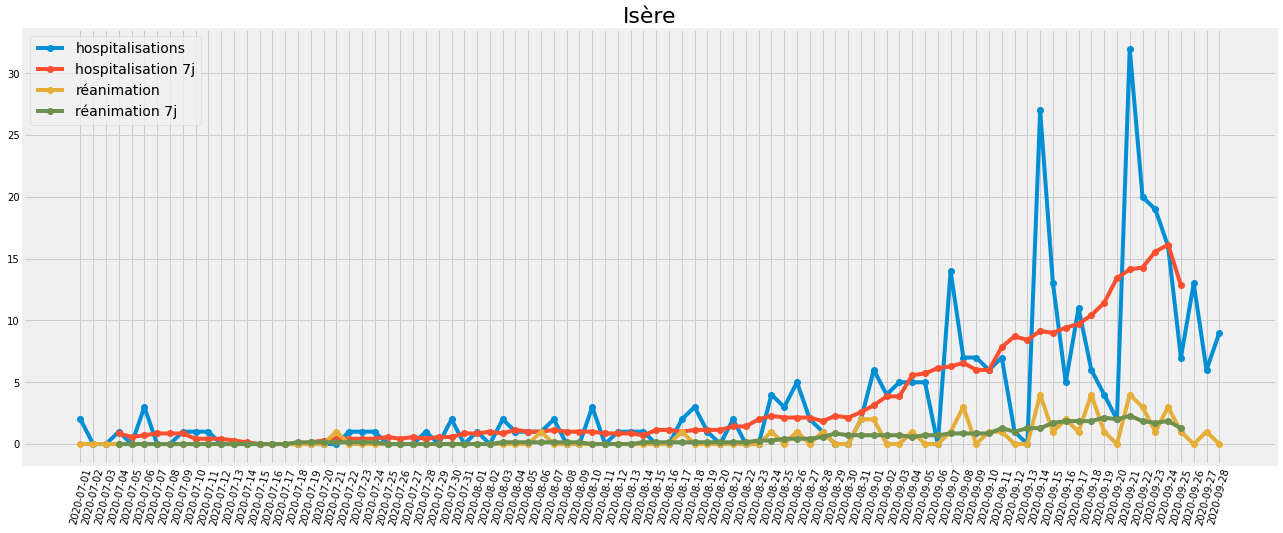


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04         5.0        1.0         6.0        1.0
2020-09-05         5.0        0.0         6.0        1.0
2020-09-06         0.0        0.0         6.0        1.0
2020-09-07        14.0        1.0         6.0        1.0
2020-09-08         7.0        3.0         7.0        1.0
2020-09-09         7.0        0.0         6.0        1.0
2020-09-10         6.0        1.0         6.0        1.0
2020-09-11         7.0        1.0         8.0        1.0
2020-09-12         1.0        0.0         9.0        1.0
2020-09-13         0.0        0.0         8.0        1.0
2020-09-14        27.0        4.0         9.0        1.0
2020-09-15        13.0        1.0         9.0        2.0
2020-09-16         5.0        2.0         9.0        2.0
2020-09-17        11.0        1.0        10.0        2.0
2020-09-18         6.0        4.0        10.0        2.0
2020-09-

In [ ]:
display_df(df[df.dep=="38"].set_index("jour", drop=True),"Isère")

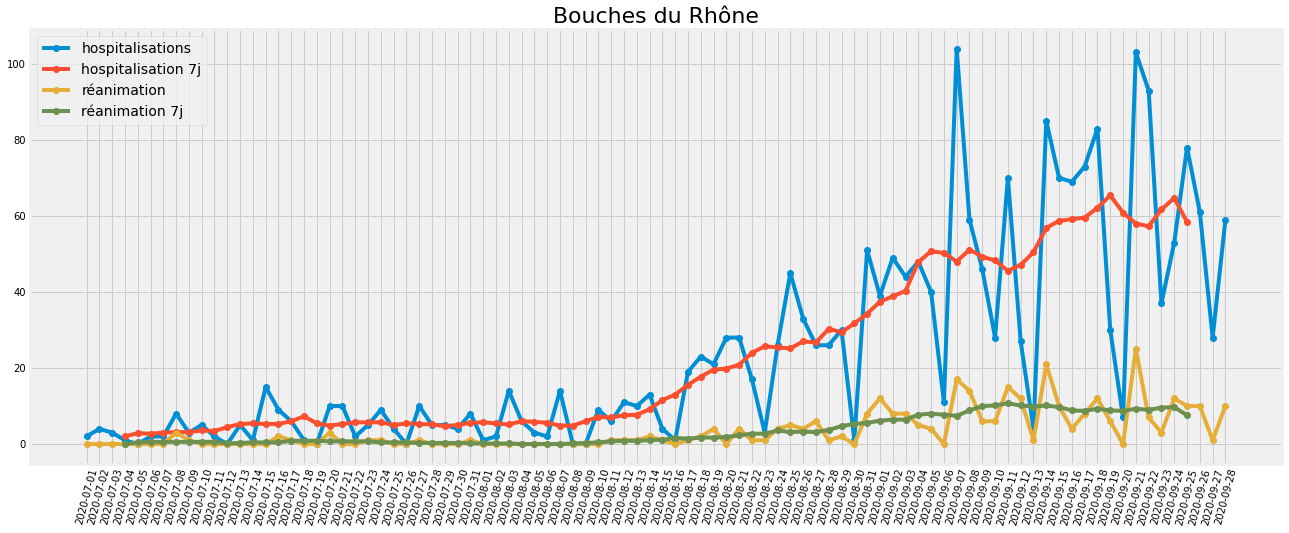


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04        48.0        5.0        48.0        8.0
2020-09-05        40.0        4.0        51.0        8.0
2020-09-06        11.0        0.0        50.0        8.0
2020-09-07       104.0       17.0        48.0        7.0
2020-09-08        59.0       14.0        51.0        9.0
2020-09-09        46.0        6.0        49.0       10.0
2020-09-10        28.0        6.0        48.0       10.0
2020-09-11        70.0       15.0        46.0       11.0
2020-09-12        27.0       12.0        47.0       10.0
2020-09-13         4.0        1.0        50.0       10.0
2020-09-14        85.0       21.0        57.0       10.0
2020-09-15        70.0       10.0        59.0       10.0
2020-09-16        69.0        4.0        59.0        9.0
2020-09-17        73.0        8.0        60.0        9.0
2020-09-18        83.0       12.0        62.0        9.0
2020-09-

In [ ]:
display_df(df[df.dep=="13"].set_index("jour", drop=True),"Bouches du Rhône")

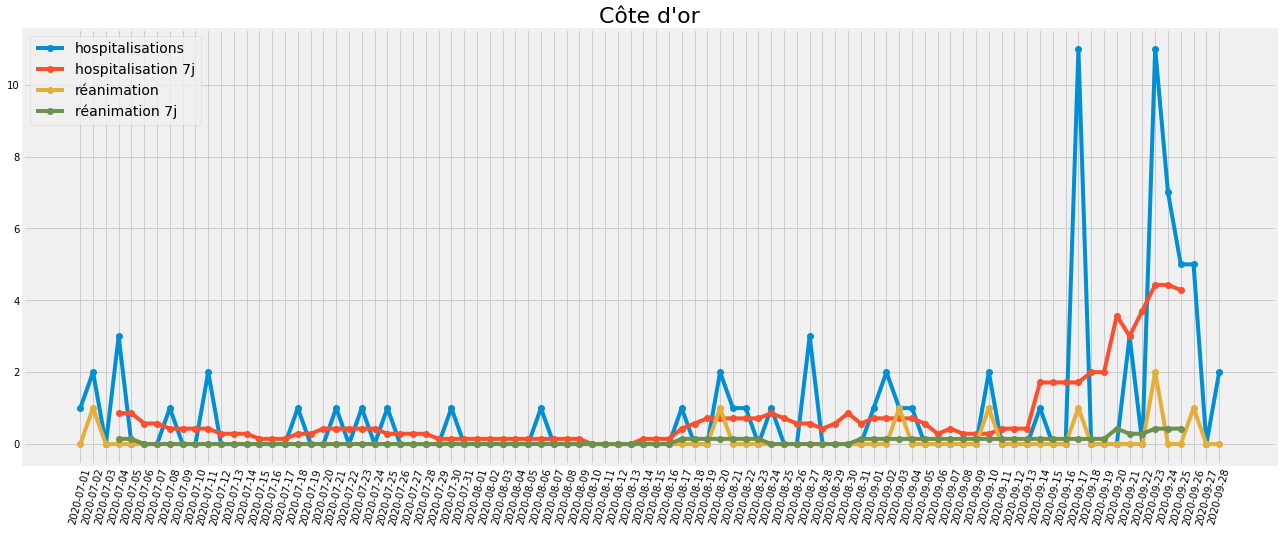


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04         1.0        0.0         1.0        0.0
2020-09-05         0.0        0.0         1.0        0.0
2020-09-06         0.0        0.0         0.0        0.0
2020-09-07         0.0        0.0         0.0        0.0
2020-09-08         0.0        0.0         0.0        0.0
2020-09-09         0.0        0.0         0.0        0.0
2020-09-10         2.0        1.0         0.0        0.0
2020-09-11         0.0        0.0         0.0        0.0
2020-09-12         0.0        0.0         0.0        0.0
2020-09-13         0.0        0.0         0.0        0.0
2020-09-14         1.0        0.0         2.0        0.0
2020-09-15         0.0        0.0         2.0        0.0
2020-09-16         0.0        0.0         2.0        0.0
2020-09-17        11.0        1.0         2.0        0.0
2020-09-18         0.0        0.0         2.0        0.0
2020-09-

In [ ]:
display_df(df[df.dep=="21"].set_index("jour", drop=True),"Côte d'or")

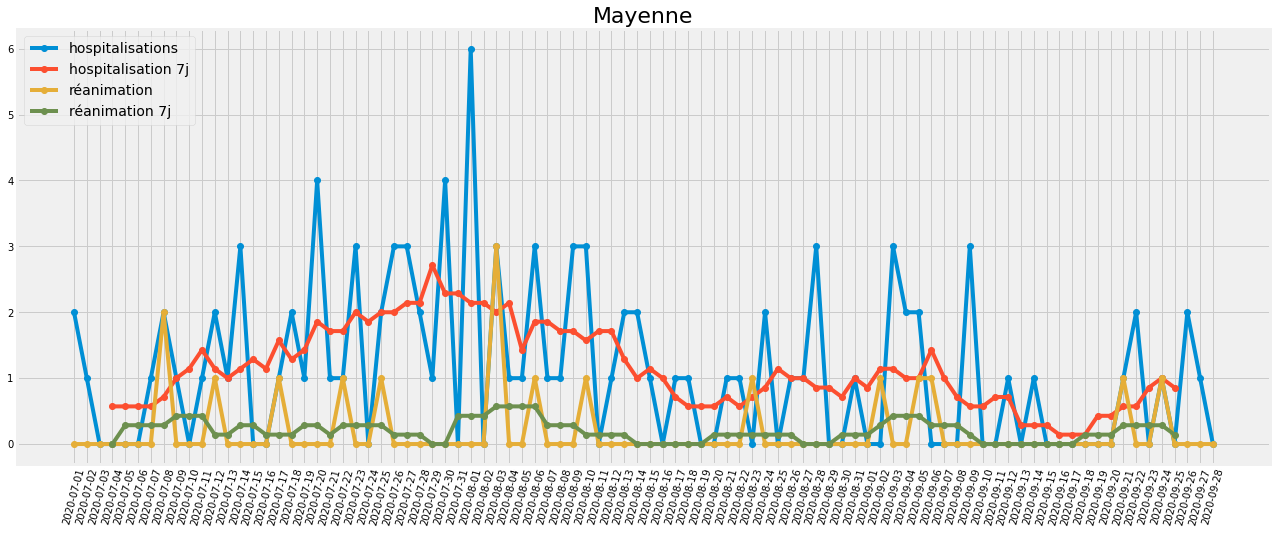


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04         2.0        0.0         1.0        0.0
2020-09-05         2.0        1.0         1.0        0.0
2020-09-06         0.0        1.0         1.0        0.0
2020-09-07         0.0        0.0         1.0        0.0
2020-09-08         0.0        0.0         1.0        0.0
2020-09-09         3.0        0.0         1.0        0.0
2020-09-10         0.0        0.0         1.0        0.0
2020-09-11         0.0        0.0         1.0        0.0
2020-09-12         1.0        0.0         1.0        0.0
2020-09-13         0.0        0.0         0.0        0.0
2020-09-14         1.0        0.0         0.0        0.0
2020-09-15         0.0        0.0         0.0        0.0
2020-09-16         0.0        0.0         0.0        0.0
2020-09-17         0.0        0.0         0.0        0.0
2020-09-18         0.0        0.0         0.0        0.0
2020-09-

In [ ]:
display_df(df[df.dep=="53"].set_index("jour", drop=True),"Mayenne")

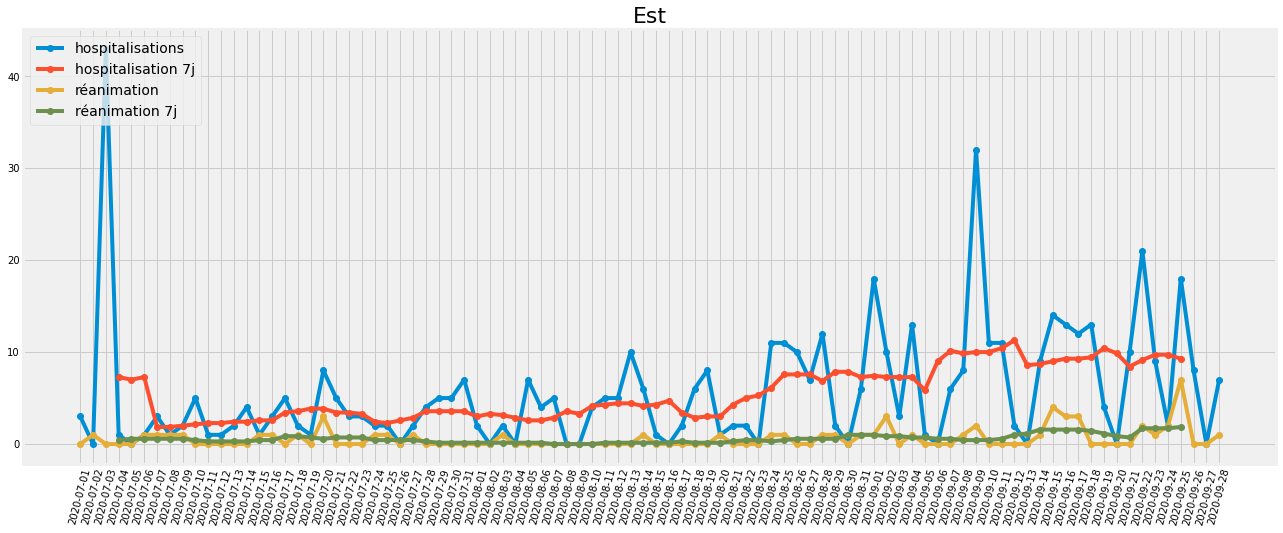


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04        13.0        1.0         7.0        1.0
2020-09-05         1.0        0.0         6.0        1.0
2020-09-06         0.0        0.0         9.0        1.0
2020-09-07         6.0        0.0        10.0        1.0
2020-09-08         8.0        1.0        10.0        0.0
2020-09-09        32.0        2.0        10.0        0.0
2020-09-10        11.0        0.0        10.0        0.0
2020-09-11        11.0        0.0        10.0        1.0
2020-09-12         2.0        0.0        11.0        1.0
2020-09-13         0.0        0.0         9.0        1.0
2020-09-14         9.0        1.0         9.0        2.0
2020-09-15        14.0        4.0         9.0        2.0
2020-09-16        13.0        3.0         9.0        2.0
2020-09-17        12.0        3.0         9.0        2.0
2020-09-18        13.0        0.0         9.0        1.0
2020-09-

In [ ]:
df1 = df[(df.dep=="67") | (df.dep == "88")| (df.dep == "54") | (df.dep == "57")]

display_df(df1.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "Est")

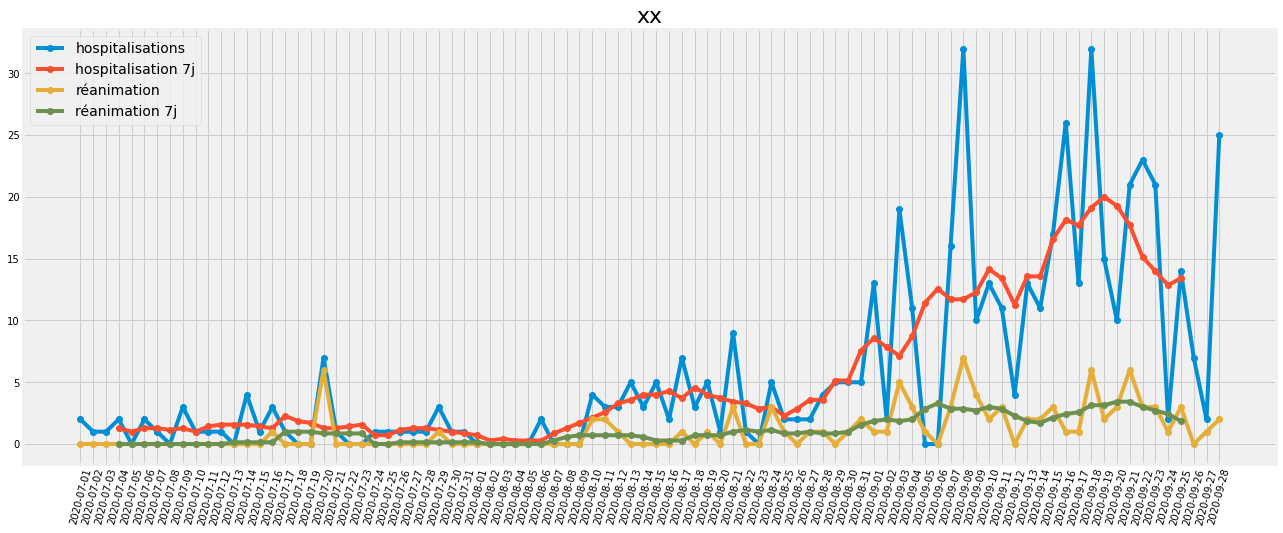


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-09-04        11.0        3.0         9.0        2.0
2020-09-05         0.0        1.0        11.0        3.0
2020-09-06         0.0        0.0        13.0        3.0
2020-09-07        16.0        3.0        12.0        3.0
2020-09-08        32.0        7.0        12.0        3.0
2020-09-09        10.0        4.0        12.0        3.0
2020-09-10        13.0        2.0        14.0        3.0
2020-09-11        11.0        3.0        13.0        3.0
2020-09-12         4.0        0.0        11.0        2.0
2020-09-13        13.0        2.0        14.0        2.0
2020-09-14        11.0        2.0        14.0        2.0
2020-09-15        17.0        3.0        17.0        2.0
2020-09-16        26.0        1.0        18.0        2.0
2020-09-17        13.0        1.0        18.0        3.0
2020-09-18        32.0        6.0        19.0        3.0
2020-09-

In [ ]:
display_df(df[df.dep=="33"].set_index("jour", drop=True),"xx", False)

In [ ]:
cumul = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-covid19",
    ";"
)

c = cumul.groupby(["dep", "jour"])["hosp", "rea"].sum().reset_index()
c.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,dep,jour,hosp,rea
19690,976,2020-09-27,16,8
19691,976,2020-09-28,16,8
19692,976,27/06/2020,68,8
19693,976,28/06/2020,68,8
19694,976,29/06/2020,66,10
